<a href="https://colab.research.google.com/github/kunwarsharik/SharikProjects/blob/master/RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os,cv2,keras,pandas as pd, matplotlib.pyplot as plt,numpy as np,tensorflow as tf

In [0]:
!pip install opencv-contrib-python

In [0]:
!wget https://sov8mq.dm.files.1drv.com/y4m4JOwqH0JXOhy8Y8QgSbFce3DlJKhuMVclXqqhqAPeUMnn1oEZ1O3seAcXqhzrrwFny_Oo3NuyLN_baLTq-eVEyhipspKOBrUrPIv3qr0DZTPvrq4SYCFInkim-_j4wa3IB6RKdSPPJ8Dhzyo8ZDRYD2xMpVVnJnhnqoEG8eG9fcBag1-dvcl9GkCF4XSlDnneyxiPNVH2uDcwCo0H_n2zA

In [0]:
!unrar x y4m4JOwqH0JXOhy8Y8QgSbFce3DlJKhuMVclXqqhqAPeUMnn1oEZ1O3seAcXqhzrrwFny_Oo3NuyLN_baLTq-eVEyhipspKOBrUrPIv3qr0DZTPvrq4SYCFInkim-_j4wa3IB6RKdSPPJ8Dhzyo8ZDRYD2xMpVVnJnhnqoEG8eG9fcBag1-dvcl9GkCF4XSlDnneyxiPNVH2uDcwCo0H_n2zA

In [0]:
ss=cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [0]:
def iou_region(b1,b2):
    x1=max(b1[0], b2[0])
    y1=max(b1[1],b2[1])
    x2=min(b1[2],b2[2])
    y2=min(b1[3],b2[3])
    if x2 < x1 or y2 < y1:
        return 0.0
    area_inter=(x2 - x1) * (y2 - y1)
    area_union=((b1[2]-b1[0])*(b1[3]-b1[1]))+((b2[2]-b2[0])*(b2[3]-b2[1]))-area_inter
    return area_inter/area_union

In [8]:
ls

NWPU-RESISC45/
sample_data/
y4m4JOwqH0JXOhy8Y8QgSbFce3DlJKhuMVclXqqhqAPeUMnn1oEZ1O3seAcXqhzrrwFny_Oo3NuyLN_baLTq-eVEyhipspKOBrUrPIv3qr0DZTPvrq4SYCFInkim-_j4wa3IB6RKdSPPJ8Dhzyo8ZDRYD2xMpVVnJnhnqoEG8eG9fcBag1-dvcl9GkCF4XSlDnneyxiPNVH2uDcwCo0H_n2zA


In [9]:
!wget "https://raw.githubusercontent.com/1297rohit/RCNN/master/Airplanes_Annotations.zip"

--2020-02-01 17:35:56--  https://raw.githubusercontent.com/1297rohit/RCNN/master/Airplanes_Annotations.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 181072 (177K) [application/zip]
Saving to: ‘Airplanes_Annotations.zip’

Airplanes_Annotatio 100%[===================>] 176.83K  --.-KB/s    in 0.04s   

2020-02-01 17:35:57 (4.74 MB/s) - ‘Airplanes_Annotations.zip’ saved [181072/181072]



In [0]:
!unzip 'Airplanes_Annotations.zip'

In [0]:
pi="NWPU-RESISC45/airplane/"
ai="Airplanes_Annotations/"

In [0]:
os.listdir(ai)

In [0]:
train_images=[]
train_labels=[]
for e,i in enumerate(os.listdir("Airplanes_Annotations")):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            img = cv2.imread(pi+filename)
            df = pd.read_csv(ai+i)
            imout = img.copy()
            anot_val=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                anot_val.append([x1,y1,x2,y2])
            ss.setBaseImage(img)
            ss.switchToSelectiveSearchFast()
            rects = ss.process()
            counter,falsecounter,flag,fflag,bflag=0,0,0,0,0
            for e,rect in enumerate(rects):
                if e < 2000 and flag == 0:
                    for anot in anot_val:
                        x,y,w,h = rect
                        iou = iou_region(anot,[x,y,x+w,y+h])
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        #print("inside")
                        flag = 1
            
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

In [0]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [15]:
X_new.shape,y_new.shape

((30229, 224, 224, 3), (30229,))

In [0]:
from keras.layers import Dense,GlobalAveragePooling2D
from keras import Model,optimizers
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split as tt
from keras.utils import to_categorical 
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint

In [0]:
y_new=to_categorical(y_new)
train,test,ytrain,ytest=tt(X_new,y_new,test_size=0.15)

In [18]:
test.shape,ytrain.shape

((4535, 224, 224, 3), (25694, 2))

In [24]:
ir = VGG16(weights='imagenet', include_top=False,input_shape=(224, 224, 3))
x=GlobalAveragePooling2D()(ir.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=ir.input, outputs=predictions)

for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(lr=0.0001), metrics=['accuracy'],loss='categorical_crossentropy')
filepath="vgg"+".hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
history=model.fit(train,ytrain, epochs=10,batch_size=None, verbose=1, validation_data=(test,ytest) ,validation_split=None,  callbacks=callbacks_list, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None)


x=GlobalAveragePooling2D()(ir.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)
model2 = Model(inputs=ir.input, outputs=predictions)
model2.load_weights("vgg"+".hdf5")
model2.compile(optimizer=Adam(lr=0.0001), metrics=['accuracy'],loss='categorical_crossentropy')
score=model2.evaluate(test,ytest)
print("vgg"+" accuracy", score[1]*100,"%") 
conf_mat=confusion_matrix(np.argmax(ytest, axis=1), np.argmax(model2.predict(test),axis=1))
print(conf_mat)

25694/25694 [==============================] - 204s 8ms/step - loss: 0.2353 - acc: 0.9055 - val_loss: 0.1198 - val_acc: 0.9581

Epoch 00001: val_loss improved from inf to 0.11981, saving model to vgg.hdf5
Epoch 2/10
25694/25694 [==============================] - 192s 7ms/step - loss: 0.1325 - acc: 0.9540 - val_loss: 0.1272 - val_acc: 0.9588

Epoch 00002: val_loss did not improve from 0.11981
Epoch 3/10
25694/25694 [==============================] - 192s 7ms/step - loss: 0.1061 - acc: 0.9635 - val_loss: 0.1184 - val_acc: 0.9579

Epoch 00003: val_loss improved from 0.11981 to 0.11837, saving model to vgg.hdf5
Epoch 4/10
25694/25694 [==============================] - 192s 7ms/step - loss: 0.0992 - acc: 0.9652 - val_loss: 0.0988 - val_acc: 0.9654

Epoch 00004: val_loss improved from 0.11837 to 0.09878, saving model to vgg.hdf5
Epoch 5/10
25694/25694 [==============================] - 192s 7ms/step - loss: 0.0848 - acc: 0.9699 - val_loss: 0.1033 - val_acc: 0.9660

Epoch 00005: val_loss did 

In [27]:
!wget https://raw.githubusercontent.com/1297rohit/RCNN/master/Images.zip

--2020-02-01 18:35:36--  https://raw.githubusercontent.com/1297rohit/RCNN/master/Images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12680736 (12M) [application/zip]
Saving to: ‘Images.zip.1’

Images.zip.1        100%[===================>]  12.09M  21.9MB/s    in 0.6s    

2020-02-01 18:35:39 (21.9 MB/s) - ‘Images.zip.1’ saved [12680736/12680736]



In [0]:
!unzip -xq "Images.zip.1" 

In [30]:
ls

Airplanes_Annotations/
Airplanes_Annotations.zip
Images/
Images.zip
Images.zip.1
NWPU-RESISC45/
sample_data/
vgg.hdf5
y4m4JOwqH0JXOhy8Y8QgSbFce3DlJKhuMVclXqqhqAPeUMnn1oEZ1O3seAcXqhzrrwFny_Oo3NuyLN_baLTq-eVEyhipspKOBrUrPIv3qr0DZTPvrq4SYCFInkim-_j4wa3IB6RKdSPPJ8Dhzyo8ZDRYD2xMpVVnJnhnqoEG8eG9fcBag1-dvcl9GkCF4XSlDnneyxiPNVH2uDcwCo0H_n2zA


In [0]:
os.listdir("Images/")

In [0]:
o,cord=[],[]
img=cv2.imread("Images/42850.jpg")
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imout = img.copy()
for e,rect in enumerate(rects):
    if e<2000:
        x,y,w,h=rect
        timage = imout[y:y+h,x:x+w]
        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
        img=resized.reshape(1,224,224,3)
        out_prob=model2.predict(img)
        o.append(out_prob[0][1])
        cord.append(rect)

In [0]:
ind=np.argpartition(np.array(o),-4)[-4:]

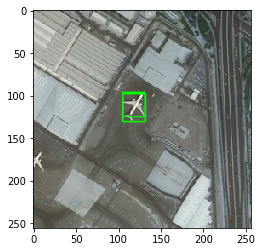

In [43]:
for cd in ind:
    x,y,w,h=cord[cd]
    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow(imout)